# Housing

In [1]:
import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

### Homeownership rate

In [2]:
data = fred_df('RHORUSQ156N')['VALUE']

data.to_csv(data_dir / 'homeown.csv', index_label='date', header=True)

datelt = dtxt(data.index[-1])['qtr1']
latest = data.iloc[-1]
ch3yr = data.diff(12).iloc[-1]

txt = val_inc_pp(ch3yr)

text = (f'As of {datelt}, the Census Bureau '+
        '\href{https://www.census.gov/housing/hvs/index.html}{report} a rate '+
        f'of home-ownership of {latest:.1f} percent (see {{\color{{violet!60!magenta}}\\textbf{{---}}}}). '+
        f'Over the past three years, the overall US homeownership rate {txt}.')

write_txt(text_dir / 'homeown.txt', text)

print(text)

node = end_node(data, 'violet!60!magenta')
write_txt(text_dir / 'homeown_node.txt', node)

As of 2020 Q3, the Census Bureau \href{https://www.census.gov/housing/hvs/index.html}{report} a rate of home-ownership of 67.4 percent (see {\color{violet!60!magenta}\textbf{---}}). Over the past three years, the overall US homeownership rate increased by a total of 3.5 percentage points.


### By Race/Ethnicity

In [3]:
url = 'https://www.census.gov/housing/hvs/data/histtab16.xlsx'

data = pd.read_excel(url)
df = data.iloc[7:-8, :-1].reset_index().drop('index', axis=1)
df.columns = ['Date', 'Total', 'White', 'Black', 'Other', 'Other2', 'Hispanic']
df = df.replace('2002r', 2002).replace('20033', 2003).dropna(how='all')

q = {1: '01', 2: '04', 3: '07', 4: '10'}

d = {}
for i, row in df.iterrows():
    if i not in d.keys():
        d[i] = {}
    if type(row['Date']) == int:
        for y in list(range(i, i+5)):
            if y in df.index:
                d[y] = {'quarter': ''}
                d[y]['year'] = row['Date']
    if (type(row['Date']) != int) & ('.' in str(row['Date'])):
        d[i]['quarter'] = q[int(row['Date'][0])]
        
    if 'year' not in d[i].keys():
        d[i] = {'date': '', 'year': '', 'quarter': ''}
    else:
        d[i]['date'] = f'{d[i]["year"]}-{d[i]["quarter"]}-01'
        
dates = {k: v['date'] for k, v in d.items()}
df['date'] = df.index.map(dates)
df = df.dropna()
df = df.set_index(pd.to_datetime(df.date))
result = df[['White', 'Black', 'Hispanic', 'Other', 'Total']]

result.to_csv(data_dir / 'homeown2.csv', index_label='date', header=True)

write_txt(text_dir / 'homeown_black_node.txt', end_node(result['Black'], 'red!20!orange!95!black'))
write_txt(text_dir / 'homeown_white_node.txt', end_node(result['White'], 'blue!80!cyan!80!black'))
write_txt(text_dir / 'homeown_hispanic_node.txt', end_node(result['Hispanic'], 'green!80!blue!85!black'))
write_txt(text_dir / 'homeown_other_node.txt', end_node(result['Other'], 'red!80!black'))

wtlt = result.White.iloc[-1]
blmax = result['Black'].max()
blidxmax = dtxt(result['Black'].idxmax())['qtr2']
blmin = result.loc['2006':, 'Black'].min()
blidxmin = dtxt(result.loc['2006':, 'Black'].idxmin())['qtr1']
bllt = result.Black.iloc[-1]
ltdt = dtxt(result.index[-1])['qtr1']
hsmax = result['Hispanic'].max()
hsidxmax = dtxt(result['Hispanic'].idxmax())['qtr2']
hslt = result['Hispanic'].iloc[-1]
compare = compare_text(hslt, hsmax, [0.3, 1.0, 3.0])
if hslt == hsmax:
    cmp_txt = 'the highest on record'
else:
    cmp_txt = f'{compare} the {hsmax:.1f} percent peak rate in {hsidxmax}'


text = (f'Around three-quarters ({wtlt:.1f} percent in {ltdt}) of non-Hispanic '+
        'white households own their home (see {\color{blue!80!cyan!80!black}\\textbf{---}}), '+
        'compared to fewer than half of black and Hispanic households. ')

write_txt(text_dir / 'homeown2.txt', text)

print(text, '\n')

txt2 = ('During the housing bubble, the homeownership rate for black households increased '+
        f'by nearly ten percentage points, peaked at {blmax:.1f} percent '+
        f'in {blidxmax}, and fell to {blmin:.1f} percent in {blidxmin}. The current '+
        f'homeownership rate for black households is {bllt:.1f} percent, as of '+
        f'{ltdt} (see {{\color{{red!20!orange!95!black}}\\textbf{{---}}}}). '+
        'The rate for Hispanic households '+
        f'of any race is {hslt:.1f} percent in {ltdt}, {cmp_txt} '+
        '(see {\color{green!80!blue!85!black}\\textbf{---}}). ')

write_txt(text_dir / 'homeown3.txt', txt2)

print(txt2)

Around three-quarters (75.8 percent in 2020 Q3) of non-Hispanic white households own their home (see {\color{blue!80!cyan!80!black}\textbf{---}}), compared to fewer than half of black and Hispanic households.  

During the housing bubble, the homeownership rate for black households increased by nearly ten percentage points, peaked at 49.7 percent in the second quarter of 2004, and fell to 40.6 percent in 2019 Q2. The current homeownership rate for black households is 46.4 percent, as of 2020 Q3 (see {\color{red!20!orange!95!black}\textbf{---}}). The rate for Hispanic households of any race is 50.9 percent in 2020 Q3, slightly below the 51.4 percent peak rate in the second quarter of 2020 (see {\color{green!80!blue!85!black}\textbf{---}}). 


<AxesSubplot:xlabel='date'>

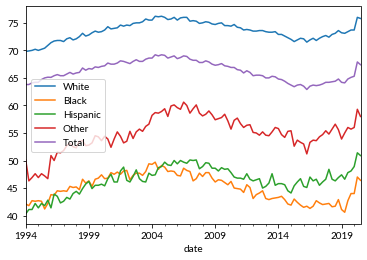

In [4]:
result.plot()

### FHFA Housing Price Index

In [2]:
df = pd.read_csv('https://www.fhfa.gov/HPI_master.csv')
srs = ['place_name', 'yr', 'period', 'index_sa']
dr = (df.loc[(df['level'] == 'USA or Census Division') & 
             (df['frequency'] == 'monthly'), srs]
        .rename({'yr': 'year', 'period': 'month'}, axis=1)
        .assign(day = 1))

data = (dr.set_index([pd.to_datetime(dr[['year', 'month', 'day']]), 
                   dr['place_name']])
          .index_sa.unstack().pct_change(12) * 100).dropna()
data.columns = [i.replace(' Division', '') for i in data.columns]
ch = data['United States']
ch.to_csv(data_dir / 'hpi.csv', index_label='date', header='True')
node = end_node(ch, 'cyan!60!blue', date=True)
write_txt(text_dir / 'fhfa_node.txt', node)

chtxt = inc_dec_percent(ch.iloc[-1])
ltdt = dtxt(ch.index[-1])['mon1']
div = data.iloc[-1].idxmax()
maxval = data.iloc[-1].max()
divs = pd.read_csv('raw/census_regions.csv')
div_list = divs[divs['Division'] == div].State.to_list()
states = f"{', '.join(div_list[:-1])}, and {div_list[-1]}"

text = (f'{chtxt} over the year ending {ltdt}. '+
          'Among Census Divisions, the fastest one-year housing '+
         f'price index growth rate in {ltdt} was {maxval:.1f} '+
         f'percent in the {div} Division, which includes {states}.')

write_txt(text_dir / 'fhfa.txt', text)
print(text)

increased by 9.1 percent over the year ending September 2020. Among Census Divisions, the fastest one-year housing price index growth rate in September 2020 was 11.2 percent in the Mountain Division, which includes Arizona, Colorado, Idaho, Montana, New Mexico, Nevada, Utah, and Wyoming.


In [3]:
t = pd.DataFrame()
for i in [-1, -2, -3, -4, -13, -25, -37]:
    t[dtxt(data.index[i])['mon6']] = data.iloc[i]
    
t['`03--`05 Average'] = data.loc['2003':'2005'].mean()
t['`09--`12 Average'] = data.loc['2009':'2012'].mean()

final = (t.rename({'United States': '\\textbf{United States}'})
          .sort_values(dtxt(data.index[-1])['mon6'], ascending=False)
          .round(1))

final.to_csv(data_dir / 'hpi.tex', sep='&', line_terminator='\\\ ', quotechar=' ')

final

,Sep `20,Aug `20,Jul `20,Jun `20,Sep `19,Sep `18,Sep `17,`03--`05 Average,`09--`12 Average
Mountain,11.2,9.7,8.0,7.7,6.6,9.2,8.6,11.1,-4.2
New England,10.1,8.0,7.0,5.3,4.6,4.9,5.4,10.3,-2.2
Pacific,9.7,8.0,6.1,5.7,4.7,5.9,8.6,18.4,-3.9
Middle Atlantic,9.6,7.8,5.8,4.8,4.7,4.3,5.2,11.3,-2.2
East South Central,9.3,9.0,7.3,6.1,6.6,5.9,4.9,5.1,-1.6
\textbf{United States},9.1,8.1,6.6,5.9,5.5,6.0,6.4,9.2,-2.5
South Atlantic,8.8,8.7,7.0,6.3,5.9,6.8,6.5,11.3,-3.7
East North Central,8.7,7.7,6.9,5.8,5.6,6.3,5.6,4.3,-2.4
West North Central,8.6,7.4,6.3,5.9,5.8,5.4,5.1,5.4,-1.1
West South Central,7.7,7.2,5.3,5.1,4.9,4.4,6.2,4.3,0.3


### Owner's equity share in real estate

In [4]:
data = fred_df('HOEREPHRE')['VALUE'].astype('float')

data.to_csv(data_dir / 'homeeq.csv', index_label='date', header=True)

datelt = dtxt(data.index[-1])['qtr1']
latest = data.iloc[-1]
ch3yr = data.diff(12).iloc[-1]
ch1yr = data.diff(4).iloc[-1]
txt = val_inc_pp(ch3yr)
txt2 = val_inc_pp(ch1yr)
avg89 = data.loc['1989'].mean()
compare = compare_text(latest, avg89, [0.05, 1.0, 5.0])

fedlink = 'https://www.federalreserve.gov/releases/z1/20191212/html/b101.htm'

text = (f'As of {datelt}, the Federal Reserve \href{{fedlink}}{{report}} '+
        f"owners\' equity is {latest:.1f} percent of residential "+
        'real estate (see {\color{blue!80!violet}\\textbf{---}}). '+
        f"Over the past three years, the owners\' equity share {txt}. "+
        f'Over the past year, the share {txt2}. The current share is {compare} '+
        f'the 1989 average of {avg89:.1f} percent.')

write_txt(text_dir / 'homeeq.txt', text)

print(text)

node = end_node(data, 'blue!80!violet')
write_txt(text_dir / 'homeeq_node.txt', node)

As of 2020 Q3, the Federal Reserve \href{fedlink}{report} owners' equity is 65.5 percent of residential real estate (see {\color{blue!80!violet}\textbf{---}}). Over the past three years, the owners' equity share increased by a total of 2.8 percentage points. Over the past year, the share increased by a total of 0.6 percentage point. The current share is substantially below the 1989 average of 67.9 percent.


### Geographic Detail for Housing Wealth Data

In [5]:
url = 'https://www.federalreserve.gov/releases/efa/state-census-region-housing-wealth.csv'

regions = ['Northeast', 'Midwest', 'West', 'South', 'US']

data = pd.read_csv(url, index_col=0)
data.index = pd.to_datetime([f'{i[:4]}-{int(i[-1]) * 3 - 2}-01' for i in data.index])
data = data.rename({'National': 'US'}, axis=1)[regions]

series = {'EOWNOCCNEQ176N': 'Northeast_Q', 
          'EOWNOCCMWQ176N': 'Midwest_Q', 
          'EOWNOCCSOQ176N': 'South_Q', 
          'EOWNOCCWEQ176N': 'West_Q', 
          'EOWNOCCUSQ176N': 'US_Q'}

df = pd.DataFrame()
for srs, name in series.items():
    url = f'http://research.stlouisfed.org/fred2/series/{srs}/downloaddata/{srs}.csv'
    s = pd.read_csv(url, index_col='DATE', parse_dates=True)['VALUE']
    df[name] = s
    
results = pd.DataFrame()
for region in regions:
    regionq = f'{region}_Q'
    regionp = f'{region}_P'
    
    total_value = data[region]
    
    quantity = df[regionq]
    
    unit_price = total_value / quantity
    
    growth = total_value.pct_change(4) * 100
    
    price_growth = unit_price.pct_change(4) * 100
    
    quantity_growth = growth - price_growth
    
    results[regionq] = quantity_growth 
    results[regionp] = price_growth 

results = results.dropna()

results.to_csv(data_dir / 'val_ooh.csv', index_label='date', float_format='%g')

results

,Northeast_Q,Northeast_P,Midwest_Q,Midwest_P,West_Q,West_P,South_Q,South_P,US_Q,US_P
2002-01-01,1.246788,12.148593,0.054483,7.979357,2.215630,10.016383,2.837168,7.103101,1.730330,9.265575
2002-04-01,2.053345,11.031070,1.638546,6.148777,1.453714,10.325106,2.037257,7.874438,1.830337,8.919039
2002-07-01,1.573850,11.265119,0.848057,6.723787,1.868985,9.641970,0.608687,9.230163,1.093095,9.469793
2002-10-01,2.360779,10.301806,0.422460,6.971540,2.457644,8.955556,1.206418,8.503507,1.464004,8.966595
2003-01-01,1.626671,10.172361,0.538033,6.685996,2.995607,8.442529,1.183082,8.243820,1.463032,8.672992
...,...,...,...,...,...,...,...,...,...,...
2018-04-01,2.125525,1.541386,2.529399,3.596621,3.015849,6.600754,2.263331,3.419525,2.464762,4.229299
2018-07-01,2.032166,1.870247,1.319744,4.321588,3.940729,5.028132,1.588974,3.599708,2.085234,4.230372
2018-10-01,2.400654,2.667958,1.746228,3.763904,2.873691,4.597203,2.313911,2.835151,2.315546,3.696151
2019-01-01,1.845684,4.399038,1.512474,5.739869,2.345565,5.179026,0.973419,6.677595,1.535048,5.715030


### Residential construction

In [6]:
key = census_key
base = 'https://api.census.gov/data/timeseries/eits/resconst/'
param = 'cell_value,time_slot_id,category_code'
t = '&time=from+1989'
dtc = '&data_type_code=TOTAL'
oth = '&for=us&seasonally_adj=yes'

url = f'{base}?get={param}&key={key}{dtc}{t}{oth}'

r = requests.get(url).json()

df = pd.DataFrame()
for series in ['APERMITS', 'ASTARTS']:
    df[series] = pd.Series(
        {pd.to_datetime(i[4]): 
         float(i[0]) for i in r[1:] if i[2] == series}
    ).sort_index()

In [7]:
df.to_csv(data_dir / 'permits.csv', index_label='date')

s = series_info(df['APERMITS'])
s['val_5yr_ago'] = df['APERMITS'].iloc[-61]

if s['days_since_match'] > 100:
    hlt = f", {s['last_matched']}"
else:
    hlt = ''
    
month = s['date_latest'].strftime('%B')

d = {}
for i in ['val_prev', 'val_year_ago', 'val_5yr_ago']:
    mo_ch = s["val_latest"] - s[i]
    mo_pch = (s["val_latest"] / s[i] - 1) * 100
    if mo_ch >= 0.1:
        txt = f'increased by {abs(mo_ch)*1000:,.0f} ({mo_pch:.1f} percent)'
    elif mo_ch <= -0.1:
        txt = f'decreased by {abs(mo_ch)*1000:,.0f} ({mo_pch:.1f} percent)'
    else:
        txt = 'were virtually unchanged'
        
    d[i] = txt
    
text = (f'In {s["date_latest_ft"]}, a seasonally-adjusted annual rate of '+
        f'{s["val_latest"]*1000:,.0f} new '+
        f'residential housing units were authorized by building permits{hlt} '+
        '(see {\color{blue!70!green}\\textbf{---}}). '+
        f'Permits issued {d["val_prev"]} over the previous month, '+
        f'{d["val_year_ago"]} over last {month}, and '+
        f'{d["val_5yr_ago"]} total over the past five years.')

write_txt(text_dir / 'permits.txt', text)

text

'In October 2020, a seasonally-adjusted annual rate of 1,544,000 new residential housing units were authorized by building permits (see {\\color{blue!70!green}\\textbf{---}}). Permits issued decreased by 1,000 (-0.1 percent) over the previous month, increased by 41,000 (2.7 percent) over last October, and increased by 386,000 (33.3 percent) total over the past five years.'

### Household formation estimates

In [8]:
files = ['histtab8.xlsx', 'hist_tab_8a_v2019.xlsx']
url = 'https://www.census.gov/housing/hvs/data/'

results = {}

for file in files:
    data = pd.read_excel(url + file).iloc[4:, :5]
    data.columns = ['category', 'Q1', 'Q2', 'Q3', 'Q4']
    years = []
    for h in data[data['Q1'] == '1st Qtr'].index - 1:
        year_raw = data.loc[h, 'Q1']
        if type(year_raw) == int:
            year = year_raw
        elif type(year_raw) == str:
            year = int(year_raw[:4])
        elif type(year) == float:
            year = year + 1
        years.append(year)
    data.loc[data['Q1'] == '1st Qtr', 'category'] = years
    data = data.dropna(subset=['category'])
    
    df = pd.DataFrame()
    levels = pd.DataFrame()
    for series in ['Owner', 'Renter']:
        srs = data.loc[data['category'].astype('str').str.contains(series)]
        srs.index = years
        srs = srs[['Q1', 'Q2', 'Q3', 'Q4']].unstack().swaplevel()
        srs.index = pd.to_datetime([f'{i[0]}-{i[1]}' for i in srs.index])
        srs = srs.sort_index()
        df[series] = srs
        levels[series] = srs
    df = df.dropna()
    df['Total'] = df.sum(axis=1)
    
    # Convert to share of total change
    for s in ['Owner', 'Renter']:  
        df[s] = ((df[s] - df[s].shift(4))
                  /df['Total'].shift(4)) * 100
        
    df = (df.reset_index()
            .drop_duplicates(subset='index', keep='last')
            .set_index('index'))
    
    results[file] = df[['Owner', 'Renter']].dropna().rolling(4).mean().loc['1989':]

In [9]:
final = results['histtab8.xlsx'].loc[:'2001'].append(results['hist_tab_8a_v2019.xlsx'].loc['2002':])
final['pop'] = (nipa_df(retrieve_table('T70100')['Data'], ['B230RC'])
                .pct_change(4).dropna() * 100)

final.to_csv(data_dir / 'hhform.csv', index_label='date')

levels = levels.dropna()
ldate = f'{levels.index[-1].year} Q{levels.index[-1].quarter}'
pdate = f'{levels.index[-2].year} Q{levels.index[-2].quarter}'
tot = levels.iloc[-1].sum() / 1000
rtot = levels['Renter'].iloc[-1] / 1000
rsh = rtot / tot * 100
otot = levels['Owner'].iloc[-1] / 1000
osh = otot / tot * 100

ch = levels.diff(4).rolling(4).mean().iloc[-1]
incdec = ['increase' if ch.sum() >= 0 else 'decrease']
chtot = [f'{abs(ch.sum()) / 1000:.1f} million' if ch.sum() > 1000 else f'{abs(ch.sum()):.0f} thousand'][0]

t = {name: [f'{abs(s) / 1000:.1f} million {["net new" if s >= 0 else "net fewer"][0]}' 
            if s > 1000 
            else f'{abs(s):.0f},000 {["net new" if s >= 0 else "net fewer"][0]}'][0]
     for name, s in [('tot', ch.sum()), ('rent', ch.Renter), ('own', ch.Owner)]}

text = (f'As of {ldate}, there are {tot:.1f} million total occupied '+
        f'housing units in the US, of which {rtot:.1f} million ({rsh:.1f} percent) '+
        f'are rented, and {otot:.1f} million ({osh:.1f} percent) are '+
        'owner-occupied. There was an average annual net total '+
        f'{incdec[0]} of {chtot} housing units '+
        f'over the year ending {ldate}, the result of {t["rent"]} '+
        f'renter households and {t["own"]} '+
        f'owner-occupied households. ')

In [10]:
totgr = final[['Owner', 'Renter']].sum(axis=1).iloc[-1]
ogr = final['Owner'].iloc[-1]
rgr = final['Renter'].iloc[-1]

final['Total'] = final[['Owner', 'Renter']].sum(axis=1)

t2 = {name: [f"{['increased' if s >= 0 else 'decreased'][0]} by {abs(s):.1f} percent"][0] 
      for name, s in final.iloc[-1].iteritems()}

t3 = {name: [f"{['an increase' if s >= 0 else 'a decreased'][0]} of {abs(s):.1f} percent"][0] 
      for name, s in final.iloc[-2].iteritems()}

t4 = {name: [f"{['a contribution' if s >= 0 else 'a reduction'][0]} of {abs(s):.1f} percent"][0] 
      for name, s in final.iloc[-1].iteritems()}

t5 = {name: [f"{[f'contributed {abs(s):.1f} percent to' if s >= 0 else f'subtracted {abs(s):.1f} percent from'][0]}"][0] 
      for name, s in final.iloc[-1].iteritems()}

text2 = (f'Over the year ending {ldate}, the total number of occupied housing units '+
         f'{t2["Total"]}, compared to {t3["Total"]} in {pdate}. Owner-occupied '+
         f'units {t5["Owner"]} total household formation on average over the year '+
         '(see\cbox{yellow!60!orange}), compared to '+
         f'{t4["Renter"]} from rented units (see\cbox{{magenta!90!blue}}).')
txt = text + text2
write_txt(text_dir / 'hhform1.txt', txt)
print(txt)

As of 2020 Q3, there are 126.7 million total occupied housing units in the US, of which 41.3 million (32.6 percent) are rented, and 85.4 million (67.4 percent) are owner-occupied. There was an average annual net total increase of 2.9 million housing units over the year ending 2020 Q3, the result of 1412,000 net fewer renter households and 4.4 million net new owner-occupied households. Over the year ending 2020 Q3, the total number of occupied housing units increased by 2.4 percent, compared to an increase of 1.9 percent in 2020 Q2. Owner-occupied units contributed 3.6 percent to total household formation on average over the year (see\cbox{yellow!60!orange}), compared to a reduction of 1.2 percent from rented units (see\cbox{magenta!90!blue}).


### New Home Sales

In [11]:
data = fred_df('HSN1F')['VALUE']

data.to_csv(data_dir / 'nhs.csv', index_label='date', header=True)

datelt = dtxt(data.index[-1])['mon1']
latest = data.iloc[-1] * 1000
ch1yr = data.pct_change(12).iloc[-1]

txt = value_text(ch1yr)

text = (f'In {datelt}, the Census Bureau '+
        '\href{https://www.census.gov/construction/nrs/pdf/newressales.pdf}{report} '+
        'seasonally-adjusted single family new homes sales totalling '+
        f'{latest:,.0f} (see {{\color{{green}}\\textbf{{---}}}}). '+
        f'Over the past year, new homes sales {txt}.')

write_txt(text_dir / 'nhs.txt', text)

print(text)

node = end_node(data, 'green', percent=False)
write_txt(text_dir / 'nhs_node.txt', node)

In October 2020, the Census Bureau \href{https://www.census.gov/construction/nrs/pdf/newressales.pdf}{report} seasonally-adjusted single family new homes sales totalling 999,000 (see {\color{green}\textbf{---}}). Over the past year, new homes sales increased 0.4 percent.
